In [1]:
import gym
from gym import spaces
import itertools
import numpy as np
import networkx as nx
import pandas as pd
from scipy.stats import *
from or_gym.envs.supply_network.inventory_management import NetInvMgmtMasterEnv
from or_gym.utils import assign_env_config
from collections import deque
import matplotlib.pyplot as plt

In [159]:
class MultiAgentNetInvMgmtEnv(NetInvMgmtMasterEnv):
    '''
    This is a multi-agent network optimization environment that is able to explore
    a variety of different models to see how they interact with one another.
    
    In this base case, each node can only submit orders to other nodes further
    upstream.
    Other cases will allow agents to partially fulfill or reject orders as well
    as put in orders and will allow for communication.
    
    Observations are limited to pipelines along connected edges, e.g. agents can
    observe what orders they have placed and sent.
    
    Nodes:
        node_id = Unique identifier for each node
        algo_class = Determines the broad class for each algorithm 
            (RL for reinforcement learning, MILP, DFO, etc.).
        algo = Some classes have multiple algorithms, we use this to differentiate
            between different approaches (e.g. DQN vs PPO).
        SC = Supply capacity
        IC = Inventory capacity
        I0 = initial inventory
        L = lead time for each edge.
        H = holding cost
        B = backlog cost
    '''
    def __init__(self, *args, **kwargs):
        
        super().__init__(self, *args, **kwargs)
        
        self.agent_ids = np.arange(1, self.num_nodes)
        
        # Disable this for now and let all nodes be RL agents
        self.algo_dict = {i: ['RL', 'PPO'] for i in self.agent_ids}
#         self.algo_dict = {
#             1: ['RL', 'PPO'],
#             2: ['Heuristic', 'ReorderQTY'],
#             3: ['RL', 'PPO'],
#             4: ['Heuristic', 'ReorderQty'],
#             5: ['Heuristic', 'ReorderQty'],
#             6: ['Heuristic', 'ReorderQty'],
#             7: ['Heuristic', 'ReorderQty'],
#             8: ['Heuristic', 'ReorderQty']
#         }
        
        assert np.allclose(self.agent_ids, np.array(list(self.algo_dict.keys()))), \
            "Agent ID's and Keys don't match."
        
        self.retail_supply_nodes = [e[0] for e in self.graph.edges() if 'L' not in self.graph.edges[e]]
        self._build_action_and_observation_spaces()
        self.reset()
            
    def _build_action_and_observation_spaces(self):
        # Set up action space and observation space for RL and
        # other models. 
        # RL needs to interact via Ray, so use standard observation and 
        # action space nomenclature. For other models, actions/obs will be
        # stored in tot_act/obs_space.
        # act/obs_dicts provide descriptive mapping of actions to nodes
        self.tot_act_space, action_space, self.act_dict = {}, {}, {}
        self.tot_obs_space, observation_space, self.obs_dict = {}, {}, {}
        
        for i in self.agent_ids:
            self.obs_dict[i] = {}
            self.obs_dict[i][0] = 'Inventory on hand'
            _obs = 1 # Inventory on hand
            _act = 0
            for e in env.graph.edges():
                if i == e[0]:
                    # Downstream connection pipeline and demand
                    L = env.graph.edges[e]['L'] + 1 if 'L' in env.graph.edges[e] else 1
                    _obs += L
                    last_entry = max(list(self.obs_dict[i].keys())) + 1
                    _new_obs = {last_entry + l: f'{l} days to delivery at node {e[1]}' if l > 0
                                else f'Demand from node {e[1]}' for l in range(L)}
                    self.obs_dict[i].update(_new_obs)
                    
                elif i == e[1]:
                    # Upstream connection pipeline
                    L = env.graph.edges[e]['L'] if 'L' in env.graph.edges[e] else 1
                    _obs += L
                    last_entry = max(list(self.obs_dict[i].keys())) + 1
                    _new_obs = {last_entry + l: f'{l} days to receive delivery from node {e[0]}'
                               for l in range(L)}
                    self.obs_dict[i].update(_new_obs)                    
                    
                    _act += 1
                    
            obs_space = spaces.Box(low=0, high=1E6, shape=(_obs,))
            act_space = spaces.Box(low=0, high=1E6, shape=(_act,))
            self.tot_obs_space[i] = obs_space
            self.tot_act_space[i] = act_space
            
#             if self.algo_dict[i][0].upper() == 'RL':
#                 observation_space[i] = obs_space
#                 action_space[i] = act_space
                
        self.observation_space = spaces.Dict(observation_space)
        self.action_space = spaces.Dict(action_space)
        
    def _update_state(self):
        self.state = None
    
    def _Step(self, action):
        '''
        Take a step in time in the multiperiod inventory management problem.
        action = number of units to request from each supplier.
        dictionary: keys are (supplier, purchaser) tuples
                    values are number of units requested from supplier
                    dimension = len(reorder_links)
        '''
        t = self.period
        if type(action) != dict: #convert to dict if a list was given
            action = {key: action[i] for i, key in enumerate(self.reorder_links)}
        
        #Place Orders
        for key in action.keys():
            request = round(max(action[key],0)) #force to integer value
            supplier = key[0]
            purchaser = key[1]
            if supplier in self.rawmat:
                self.R.loc[t,(supplier, purchaser)] = request #accept request since supply is unlimited
                self.S.loc[t,(supplier, purchaser)] = request
            elif supplier in self.distrib:
                X_supplier = self.X.loc[t,supplier] #request limited by available inventory at beginning of period
                self.R.loc[t,(supplier, purchaser)] = min(request, X_supplier)
                self.S.loc[t,(supplier, purchaser)] = min(request, X_supplier)
            elif supplier in self.factory:
                C = self.graph.nodes[supplier]['C'] #supplier capacity
                v = self.graph.nodes[supplier]['v'] #supplier yield
                X_supplier = self.X.loc[t,supplier] #on-hand inventory at beginning of period
                self.R.loc[t,(supplier, purchaser)] = min(request, C, v*X_supplier)
                self.S.loc[t,(supplier, purchaser)] = min(request, C, v*X_supplier)
            
        #Receive deliveries and update inventories
        for j in self.main_nodes:
            #update pipeline inventories
            incoming = []
            for k in self.graph.predecessors(j):
                L = self.graph.edges[(k,j)]['L'] #extract lead time
                if t - L >= 0: #check if delivery has arrived
                    delivery = self.R.loc[t-L,(k,j)]
                else:
                    delivery = 0
                incoming += [delivery] #update incoming material
                self.Y.loc[t+1,(k,j)] = self.Y.loc[t,(k,j)] - delivery + self.R.loc[t,(k,j)]

            #update on-hand inventory
            if 'v' in self.graph.nodes[j]: #extract production yield
                v = self.graph.nodes[j]['v']
            else:
                v = 1
            outgoing = 1/v * np.sum([self.S.loc[t,(j,k)] for k in self.graph.successors(j)]) #consumed inventory (for requests placed)
            self.X.loc[t+1,j] = self.X.loc[t,j] + np.sum(incoming) - outgoing
            
        # demand is realized
        for j in self.retail:
            for k in self.market:
                #read user specified demand. if all zeros, use demand_dist instead.
                Demand = self.graph.edges[(j,k)]['user_D']
                if np.sum(Demand) > 0:
                    self.D.loc[t,(j,k)] = Demand[t]
                else:
                    Demand = self.graph.edges[(j,k)]['demand_dist']
                    self.D.loc[t,(j,k)] = Demand.rvs(**self.graph.edges[(j,k)]['dist_param'])
                if self.backlog and t >= 1:
                    D = self.D.loc[t,(j,k)] + self.U.loc[t-1,(j,k)]
                else:
                    D = self.D.loc[t,(j,k)]
                # Satisfy demand up to available level
                X_retail = self.X.loc[t+1,j] #get inventory at retail before demand was realized
                self.S.loc[t,(j,k)] = min(D, X_retail) #perform sale
                self.X.loc[t+1,j] -= self.S.loc[t,(j,k)] #update inventory
                self.U.loc[t,(j,k)] = D - self.S.loc[t,(j,k)] #update unfulfilled orders

        # calculate profit
        for j in self.main_nodes:
            a = self.alpha
            # Sales revenue
            SR = np.sum([self.graph.edges[(j,k)]['p'] * self.S.loc[t,(j,k)] 
                         for k in self.graph.successors(j)])
            # Purchasing costs
            PC = np.sum([self.graph.edges[(k,j)]['p'] * self.R.loc[t,(k,j)] 
                         for k in self.graph.predecessors(j)])
            if j not in self.rawmat:
                # Holding costs
                HC = self.graph.nodes[j]['h'] * self.X.loc[t+1,j] + \
                    np.sum([self.graph.edges[(k,j)]['g'] * self.Y.loc[t+1,(k,j)] 
                            for k in self.graph.predecessors(j)])
            else:
                HC = 0
            if j in self.factory:
                # Operating costs
                OC = self.graph.nodes[j]['o'] / self.graph.nodes[j]['v'] * \
                    np.sum([self.S.loc[t,(j,k)] 
                            for k in self.graph.successors(j)])
            else:
                OC = 0
            if j in self.retail:
                # Unfulfilled penalty
                UP = np.sum([self.graph.edges[(j,k)]['b'] * self.U.loc[t,(j,k)] 
                             for k in self.graph.successors(j)])
            else:
                UP = 0
            self.P.loc[t,j] = a**t * (SR - PC - OC - HC - UP)
        
        # update period
        self.period += 1

        # set reward (profit from current timestep)
        reward = self.P.loc[t,:].sum()
        
        # determine if simulation should terminate
        if self.period >= self.num_periods:
            done = True
        else:
            done = False
            # update stae
            self._update_state()

        return self.state, reward, done, {}
    
    def step(self, action):
        self.state, reward, done, info = self._Step(action)
        # TODO: change reward to return reward for each node
        rewards = {i: reward for i in self.agent_ids}
        dones = {i: done for i in self.agent_ids}
        dones['__all__'] = done
        info = {i: info for i in self.agent_ids}
        
        return self.state, reward, done, info
        
env = MultiAgentNetInvMgmtEnv()

In [153]:
env.tot_obs_space

{1: Box(0.0, 1000000.0, (12,), float32),
 2: Box(0.0, 1000000.0, (38,), float32),
 3: Box(0.0, 1000000.0, (29,), float32),
 4: Box(0.0, 1000000.0, (22,), float32),
 5: Box(0.0, 1000000.0, (16,), float32),
 6: Box(0.0, 1000000.0, (27,), float32),
 7: Box(0.0, 1000000.0, (4,), float32),
 8: Box(0.0, 1000000.0, (5,), float32)}

In [136]:
env.obs_dict

{1: {0: 'Inventory on hand',
  1: 'Demand from node 0',
  2: '0 days to receive delivery from node 2',
  3: '1 days to receive delivery from node 2',
  4: '2 days to receive delivery from node 2',
  5: '3 days to receive delivery from node 2',
  6: '4 days to receive delivery from node 2',
  7: '0 days to receive delivery from node 3',
  8: '1 days to receive delivery from node 3',
  9: '2 days to receive delivery from node 3'},
 2: {0: 'Inventory on hand',
  1: 'Demand from node 1',
  2: '1 days to delivery at node 1',
  3: '2 days to delivery at node 1',
  4: '3 days to delivery at node 1',
  5: '4 days to delivery at node 1',
  6: '5 days to delivery at node 1',
  7: '0 days to receive delivery from node 4',
  8: '1 days to receive delivery from node 4',
  9: '2 days to receive delivery from node 4',
  10: '3 days to receive delivery from node 4',
  11: '4 days to receive delivery from node 4',
  12: '5 days to receive delivery from node 4',
  13: '6 days to receive delivery from no

In [169]:
env.X.iloc[0]

,1,2,3,4,5,6
0,100.0,110.0,80.0,400.0,350.0,380.0
1,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0


In [179]:
env.X.iloc[env.period][6]

380.0

In [181]:
states = {}
for i in env.agent_ids:
    try:
        _state = np.array([env.X.iloc[env.period][i]])
    except KeyError:
        # No inventory on hand
        _state = np.array([0])
    # Get retail demand
    if i in env.retail_supply_nodes:
        demand = np.hstack([env.D[d].iloc[env.period] 
            for d in env.retail_links if i==d[0]])
        _state = np.hstack([_state, demand])
        
    for e in env.graph.edges():
        # Get demand info from downstream connections
        if i == e[0] and i not in env.retail_supply_nodes:
            demand = np.array([env.R[e].iloc[env.period]])
            _state = np.hstack([_state, demand])
            
        # Get pipeline info from downstream connections
        if i == e[0] and 'L' in env.graph.edges[e]:
            L = env.graph.edges[e]['L']
            if L == 0:
                continue
            if env.period == 0:
                _ds_pipe = np.array([env.Y[e].iloc[env.period]])
            else:
                _ds_pipe = env.Y[e].iloc[max(env.period-L, 0):env.period].values
                
            pl = len(_ds_pipe)
            if pl < L:
                ds_pipe = np.zeros(L)
                ds_pipe[-pl:] += _ds_pipe
            else:
                ds_pipe = _ds_pipe.copy()
                
            _state = np.hstack([_state, ds_pipe])
            
        # Get pipeline info from upstream connections
        if i == e[1] and 'L' in env.graph.edges[e]:
            L = env.graph.edges[e]['L']
            if L == 0:
                continue
            if env.period == 0:
                _us_pipe = np.array([env.Y[e].iloc[env.period]])
            else:
                _us_pipe = env.Y[e].iloc[max(env.period-L, 0):env.period].values
                
            pl = len(_us_pipe)
            if pl < L:
                us_pipe = np.zeros(L)
                us_pipe[-pl:] += _us_pipe
            else:
                us_pipe = _us_pipe.copy()
                
            _state = np.hstack([_state, us_pipe])
            
    states[i] = _state.copy()

In [182]:
states

{1: array([100.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 2: array([110.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.]),
 3: array([80.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.]),
 4: array([400.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 5: array([350.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.]),
 6: array([380.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.]),
 7: array([0., 0., 0., 0.]),
 8: array([0., 0., 0., 0., 0.])}

In [183]:
for k, v in states.items():
    print(f"Agent = {k}\tState Dim = {len(v)}\tExpected Dim = {env.tot_obs_space[k].shape[0]}" +
          f"\tIndexed State = {len(env.obs_dict[k])}")

Agent = 1	State Dim = 10	Expected Dim = 10	Indexed State = 10
Agent = 2	State Dim = 35	Expected Dim = 35	Indexed State = 35
Agent = 3	State Dim = 27	Expected Dim = 27	Indexed State = 27
Agent = 4	State Dim = 21	Expected Dim = 21	Indexed State = 21
Agent = 5	State Dim = 14	Expected Dim = 14	Indexed State = 14
Agent = 6	State Dim = 26	Expected Dim = 26	Indexed State = 26
Agent = 7	State Dim = 4	Expected Dim = 4	Indexed State = 4
Agent = 8	State Dim = 5	Expected Dim = 5	Indexed State = 5


In [168]:
states

{1: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 2: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]),
 3: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 4: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]),
 5: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 6: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 7: array([0., 0., 0., 0.]),
 8: array([0., 0., 0., 0., 0.])}

In [51]:
if self.period == 0:
    _pipeline = [[self.Y[k].iloc[0]]
        for k, v in self.lead_times.items()]
else:
    _pipeline = [self.Y[k].iloc[max(self.period-v,0):self.period].values
        for k, v in self.lead_times.items()]

0.0

In [ ]:
# State is a concatenation of demand, inventory, and pipeline at each time step
demand = np.hstack([self.D[d].iloc[self.period] for d in self.retail_links])
inventory = np.hstack([self.X[n].iloc[self.period] for n in self.main_nodes])

# Pipeline values won't be of proper dimension if current
# current period < lead time. We need to add 0's as padding.
if self.period == 0:
    _pipeline = [[self.Y[k].iloc[0]]
        for k, v in self.lead_times.items()]
else:
    _pipeline = [self.Y[k].iloc[max(self.period-v,0):self.period].values
        for k, v in self.lead_times.items()]
pipeline = []
for p, v in zip(_pipeline, self.lead_times.values()):
    if v == 0:
        continue
    if len(p) <= v:
        pipe = np.zeros(v)
        pipe[-len(p):] += p
    pipeline.append(pipe)
pipeline = np.hstack(pipeline)
self.state = np.hstack([demand, inventory, pipeline])

In [13]:
env.X

,1,2,3,4,5,6
0,100.0,110.0,80.0,400.0,350.0,380.0
1,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# Check that observation dictionaries match each other
for k, v in env.obs_dict.items():
    if len(v) != env.tot_obs_space[k].shape[0]:
        print(f'Space at node {k} = {len(v)} does not match {env.tot_obs_space[k].shape[0]}')
    else:
        print(f'Node {k} matches')

Node 1 matches
Node 2 matches
Node 3 matches
Node 4 matches
Node 5 matches
Node 6 matches
Node 7 matches
Node 8 matches


In [67]:
env.action_space

Dict(1:Box(0.0, 1000000.0, (2,), float32), 3:Box(0.0, 1000000.0, (2,), float32))

In [68]:
env.adjacency_matrix

array([[1, 0],
       [2, 1],
       [3, 1],
       [4, 2],
       [4, 3],
       [5, 2],
       [6, 2],
       [6, 3],
       [7, 4],
       [7, 5],
       [8, 5],
       [8, 6]])

In [37]:
[(e, env.graph.edges[e]['L']) for e in env.graph.edges() if 'L' in env.graph.edges[e]]

[((2, 1), 5),
 ((3, 1), 3),
 ((4, 2), 8),
 ((4, 3), 10),
 ((5, 2), 9),
 ((6, 2), 11),
 ((6, 3), 12),
 ((7, 4), 0),
 ((7, 5), 1),
 ((8, 5), 2),
 ((8, 6), 0)]

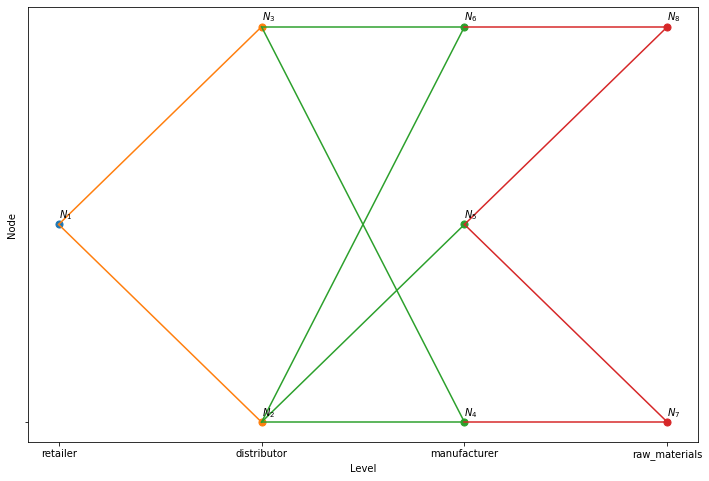

In [20]:
env.plot_network()